In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [65]:
#import libraries
import torch
from torch import nn
from  torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import os
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import torchvision
torch.__version__

'2.1.2+cpu'

In [2]:
#set up device agnostic cpde
device = "cuda" if torch.cuda.is_available else "cpu"
device = "cpu"
device

'cpu'

#### Preparing dataset class

In [53]:
def create_dataset():
    
    #Write transform  for eaxh image
    data_transform = transforms.Compose([
    #resize image
    transforms.Resize(size=(64,64)),
    #Flip image horizontally
    transforms.RandomHorizontalFlip(p=0.5),

    #Turn image to torch tensor
    transforms.ToTensor()]
)
    
    #set dataset
    data_dir = "/kaggle/input/mkd-test/scraped_images"
    data = datasets.ImageFolder(root=data_dir,
                                  transform=data_transform,
                                  target_transform=None)
    
    class_dict = data.class_to_idx

    
    #divide into train and test

    # Determine the dataset size
    total_size = len(data)
    train_size = int(0.8 * total_size)
    test_size = total_size - train_size

    # Randomly split the dataset into train and test
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    
        #divide inot train and test dataloader
    BATCH_SIZE = 1
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size = BATCH_SIZE ,
                                  num_workers = os.cpu_count(),
                                  shuffle = True

                                  )
    test_dataloader = DataLoader(dataset =test_dataset,
                                 batch_size = BATCH_SIZE,
                                 num_workers = 1,
                                 shuffle = False


    )
    print(f"Size of train:{len(train_dataloader)}, size of test:  {len(test_dataloader)}")
    
    
    return train_dataloader,test_dataloader,class_dict

train_loader ,test_loader,class_dict = create_dataset()


Size of train:241, size of test:  61


In [54]:
class_dict

{'JUMBO BAG RED RETROSPOT': 0,
 'REGENCY CAKESTAND 3 TIER': 1,
 'WHITE HANGING HEART T-LIGHT HOLDER': 2}

#### Create model

In [44]:
class TinyVGG(nn.Module):
  """Creates the TinyVGG architecture.

  Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
  See the original architecture here: https://poloclub.github.io/cnn-explainer/
  
  Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),  
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from? 
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
      )
    
  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x = self.classifier(x)
      return x


In [45]:
NUM_CLASSES = 3
model = TinyVGG(
    input_shape=3,hidden_units=10, 
    output_shape=NUM_CLASSES).to(device)


#### Custom training and evaluation function

In [46]:

"""
Contains functions for training and testing a PyTorch model.
"""
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
    
    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()
  
  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0
  
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    
    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 
  
  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0
  
  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)
  
          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()
          
          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
          
  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
      
      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

### custom model saving function

In [47]:
from pathlib import Path
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.
  
  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  
  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [48]:
# Setup hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
results = train(model=model,
             train_dataloader=train_loader,
             test_dataloader=test_loader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
save_model(model=model,
                 target_dir="models",
                 model_name="tinyvgg_model_1.pth")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9069 | train_acc: 0.6017 | test_loss: 0.8231 | test_acc: 0.5574
Epoch: 2 | train_loss: 0.8756 | train_acc: 0.5809 | test_loss: 0.8608 | test_acc: 0.5574
Epoch: 3 | train_loss: 0.8914 | train_acc: 0.6058 | test_loss: 0.7974 | test_acc: 0.5574
Epoch: 4 | train_loss: 0.8868 | train_acc: 0.6058 | test_loss: 0.8383 | test_acc: 0.5574
Epoch: 5 | train_loss: 0.8874 | train_acc: 0.6058 | test_loss: 0.8657 | test_acc: 0.5574
Epoch: 6 | train_loss: 0.8933 | train_acc: 0.6058 | test_loss: 0.7942 | test_acc: 0.5574
Epoch: 7 | train_loss: 0.8785 | train_acc: 0.6058 | test_loss: 0.8458 | test_acc: 0.5574
Epoch: 8 | train_loss: 0.9124 | train_acc: 0.6100 | test_loss: 0.8317 | test_acc: 0.5574
Epoch: 9 | train_loss: 0.8814 | train_acc: 0.6058 | test_loss: 0.8063 | test_acc: 0.5574
Epoch: 10 | train_loss: 0.8842 | train_acc: 0.6058 | test_loss: 0.8132 | test_acc: 0.5574
Epoch: 11 | train_loss: 0.8657 | train_acc: 0.5975 | test_loss: 0.8100 | test_acc: 0.5410
Epoch: 12 | train_l

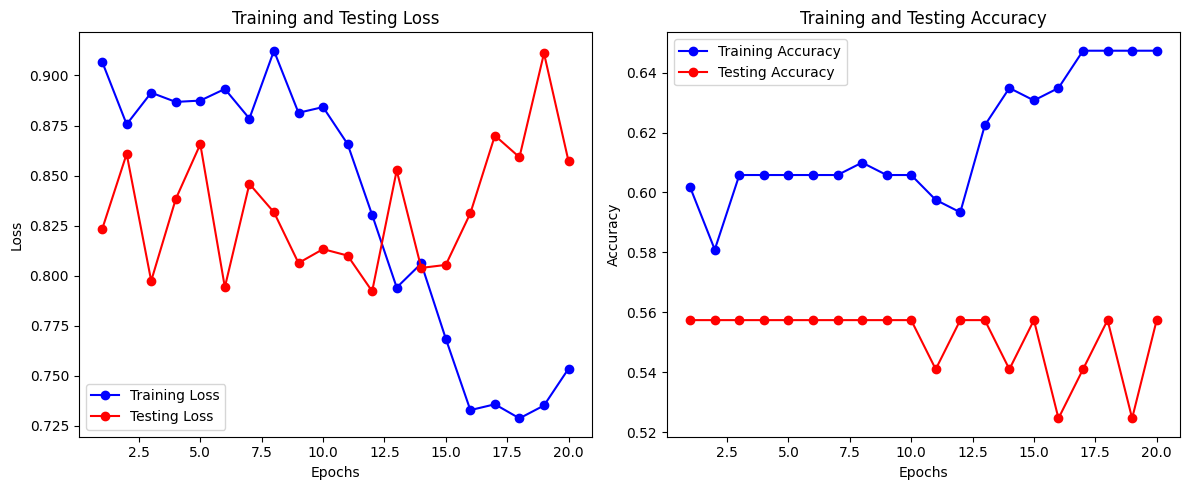

In [49]:
def plot_results(results):
    epochs = range(1, len(results['train_loss']) + 1)

    # Plotting training and testing losses
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, results['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, results['test_loss'], 'ro-', label='Testing Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and testing accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, results['test_acc'], 'ro-', label='Testing Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_results(results)

In [51]:
#load model
model_load = TinyVGG(
    input_shape=3,hidden_units=10, 
    output_shape=3).to(device)
 

# Load in the saved state_dict()

MODEL_SAVE_PATH = f"/kaggle/working/models/tinyvgg_model_1.pth"

model_load.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = model_load.to(device)

In [56]:
def load_tinyvgg_model(model_save_path, input_shape, hidden_units, output_shape, device):
    """
    Loads a TinyVGG model from a specified path and sends it to a specified device.

    Args:
    model_save_path (str): Path to the saved model file (.pth).
    input_shape (int): Number of input channels.
    hidden_units (int): Number of hidden units in the convolutional layers.
    output_shape (int): Number of output units (classes).
    device (str): The device to load the model onto ('cpu' or 'cuda').

    Returns:
    torch.nn.Module: Loaded PyTorch model ready for inference or further training.
    """
    # Initialize the model
    model_load = TinyVGG(input_shape=input_shape, hidden_units=hidden_units, output_shape=output_shape)

    # Load the model's saved state dictionary
    model_load.load_state_dict(torch.load(model_save_path))
model
    # Send the model to the specified device
    loaded_model = model_load.to(device)

    return loaded_model
loaded_model = load_tinyvgg_model(input_shape=3,
                                  model_save_path="/kaggle/working/models/tinyvgg_model_1.pth",
                                  hidden_units=10,
                                  output_shape=3,
                                  device =device
)



In [57]:
loaded_model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [58]:
#Write transform  for eaxh image
data_transform = transforms.Compose([
    #resize image
    transforms.Resize(size=(64,64)),
    #Flip image horizontally
    transforms.RandomHorizontalFlip(p=0.5),

    #Turn image to torch tensor
    transforms.ToTensor()]
)

In [59]:
class_dict

{'JUMBO BAG RED RETROSPOT': 0,
 'REGENCY CAKESTAND 3 TIER': 1,
 'WHITE HANGING HEART T-LIGHT HOLDER': 2}

In [70]:
from PIL import Image
def predict(model: torch.nn.Module, 
                        image_path: str, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = Image.open(image_path)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    #target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    for key, val in class_dict.items():
        if val == target_image_pred_label:
            class_name = key
            
    return class_name ,target_image_pred_label
    
    # 8. Plot the image alongside the prediction and prediction probability

In [71]:
x,y = predict(model=loaded_model,image_path="/kaggle/input/mkd-test/scraped_images/JUMBO BAG RED RETROSPOT/JUMBO BAG RED RETROSPOT 1.jpg",
              transform = data_transform)
              
              
x

'WHITE HANGING HEART T-LIGHT HOLDER'

In [72]:
y

tensor([2])

In [ ]:
tinyvgg_model(input_shape=3,
                                  model_save_path="/kaggle/working/models/tinyvgg_model_1.pth",
                                  hidden_units=10,
                                  output_shape=3,
                                  device =device

In [ ]:
class Predictor:
    
    def __init__(self,model):
        self.model = model
    
    def load_tiny(self):
    """
    Loads a TinyVGG model from a specified path and sends it to a specified device.

    Args:
    model_save_path (str): Path to the saved model file (.pth).
    input_shape (int): Number of input channels.
    hidden_units (int): Number of hidden units in the convolutional layers.
    output_shape (int): Number of output units (classes).
    device (str): The device to load the model onto ('cpu' or 'cuda').

    Returns:
    torch.nn.Module: Loaded PyTorch model ready for inference or further training.
    """
    # Initialize the model
    

    # Load the model's saved state dictionary
    model.load_state_dict(torch.load(model_save_path))

    # Send the model to the specified device
    loaded_model = model.to(device)
    return loaded_model

    